## Sentiment Analysis on  [Twitter US Airline](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) data

The Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets regarding major U.S. airlines.

**Imports**

In [0]:
import os
import random
import io
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
import numpy
nltk.download('punkt')

Using TensorFlow backend.


In [0]:
# Upload training data and test data to google colab
from google.colab import files
dataset = files.upload()

Saving tweet.csv to tweet (1).csv


**Functions**

In [0]:
def read_in(path_to_file):
    out = []
    with open(path_to_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            if row[1] == "negative":
                out.append([-1, row[10]])
            elif row[1] == "neutral":
                out.append([0, row[10]])
            elif row[1] == "positive":
                out.append([1, row[10]])
        random.shuffle(out)
    return out

  
def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        cleaned = clean_regex(row[1].lower())
        if cleaned.__len__() > 1:
            tokenized = nltk.word_tokenize(cleaned)
            # pos_tagged = nltk.pos_tag(tokenized)
            tweet.append(tokenized)
            label.append(row[0])
    print("Done")
    return tweet, label


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    cleaned = re.sub('@.*?(?:\s|$)', '', tweet)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    cleaned4 = re.sub('#','', cleaned3)
    return cleaned4

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def get_embeddings(sentences, max_words=35):
    """
    Retrieves a 300 dim. embedding vector from ConceptNet for each word 
    of a sentence. (Only retrieves the first max_words words (tokens) of a tweet)
    """
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 1000 == 0:
            print(str(i))
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), concept_hash)
                if embedding is not None:
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
    return results

def fill_list(data, max_words=35):
  """
  Fills or cuts list of tokens for a tweet at maxdim, to ensure consistent vector dimensions
  """
  res = []
  for row in data:
      copy = row
      if len(row) < max_words:
          copy += [''] * (max_words - len(row))
      elif len(row) > max_words:
          copy = row[:max_words]   
      res.append(copy)
  return res

def label_conversion(label_data):
  """
  Converts label to normalized value
  """
  out = numpy.zeros(shape=(label_data.__len__(),3), dtype="int8")
  for i, label in enumerate(label_data):
      if label == -1:
          out[i][0] = 1
      elif label == 0:
          out[i][1] = 1
      elif label == 1:
          out[i][2] = 1
  return out



**Preprocessing**

In [0]:
data, label = preprocess(read_in('tweet.csv'))

Preprocessing...
Done


**Split into training and validation set**

In [0]:
# Split training and test data
split_test = 14000
training_data = data[:split_test]
training_label = label[:split_test]
test_data = data[split_test:]
test_label = label[split_test:]

# Split training data into training and validation data
split_val = 11000
train_data = training_data[:split_val]
train_label = np.asarray(training_label[:split_val])
val_data = training_data[split_val:]
val_label = np.asarray(training_label[split_val:])

# Convert labels
test_label= label_conversion(test_label)
train_label = label_conversion(train_label)
val_label = label_conversion(val_label)

**Download ConceptNet word embeddings and load into RAM**

In [0]:
file = !wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
import gzip
import shutil
with gzip.open("numberbatch-en-17.06.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
concept_hash = parse_to_dict("numberbatch-en.txt")

**Download ELMo word embeddings and load into RAM**

In [0]:
!git clone https://github.com/HIT-SCIR/ELMoForManyLangs
# install pytorch and allennlp (requirement for elmo)
!pip3 install torch torchvision
!pip install allennlp


In [0]:
%cd ELMoForManyLangs/
!python setup.py install
!wget http://vectors.nlpl.eu/repository/11/144.zip
!unzip 144.zip

In [0]:
# Upload customized config.json and cnn_50_100_512_4096_sample.json
from google.colab import files
files.upload()

Saving config.json to config.json


{'config.json': b'{"seed": 1, "gpu": 3, "train_path": "/users4/conll18st/raw_text/English/en-20m.raw", "valid_path": null, "test_path": null, "config_path": "cnn_50_100_512_4096_sample.json", "word_embedding": null, "optimizer": "adam", "lr": 0.001, "lr_decay": 0.8, "model": "/users4/conll18st/elmo/src/final_models/en.model", "batch_size": 32, "max_epoch": 10, "clip_grad": 5, "max_sent_len": 20, "min_count": 3, "max_vocab_size": 150000, "save_classify_layer": false, "valid_size": 0, "eval_steps": 10000}\r\n'}

In [0]:
from elmoformanylangs import Embedder
e = Embedder('.')

**Retrieve word embedding vectors for training and validation data**

In [0]:
# ElMo
train_embedding_matrix = np.asarray(e.sents2elmo(fill_list(train_data)))
val_embedding_matrix = np.asarray(e.sents2elmo(fill_list(val_data)))

**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [0]:
model = models.Sequential()
model.add(layers.Dense(35, activation='relu', input_shape=(35,1024,)))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(train_embedding_matrix,
                    train_label_vector,
                    epochs=15,
                    batch_size=256,
                    validation_data=(val_embedding_matrix, val_label_vector), verbose=1)

W0807 15:12:13.014445 139717268531072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 15:12:13.030658 139717268531072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 15:12:13.038107 139717268531072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 15:12:13.106380 139717268531072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 15:12:13.129452 139717268531072 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35, 35)            35875     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1225)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 35)                42910     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 108       
Total params: 78,893
Trainable params: 78,893
Non-trainable params: 0
_________________________________________________________________
None


ValueError: ignored

**Plotting accuracy and loss in the training phase**

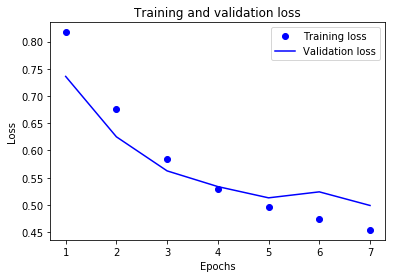

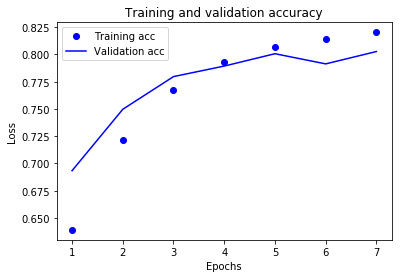

In [0]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [0]:
# ConceptNet
test_embedding_matrix = get_embeddings(test_data)
# ELMo
#test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))

results = model.evaluate(test_embedding_matrix, test_label_vector)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

0
639/639 [==============================] - 0s 121us/step
Loss:  0.5136687318110876
Accuracy:  0.7934272302335044


**Results**

We trained our network on 140.000 samples (120.000 training and 20.000 validation samples) and used the word embedding vectors obtained by ConceptNet. Unfortunately, due to hardware limitations, this is less than a 10th of the available training data. However, as we tested the model with multiple random subsets of the 1.6M samples we achieved accuracies in-between 78%-82%, and therefore perform as good as several state-of-the-art approaches [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf), [Ebert et al.](https://www.aclweb.org/anthology/W15-2915). Accuracy and loss improve until epoch 6-10 and more or less stagnate until epoch 20.